Titanic from Kaggle!!

At the begging we import the packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import sklearn
import xgboost as xgb
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, KFold

Next we upload the datasets

In [2]:
train_y= pd.read_csv('/home/yannis/Desktop/jupyter yannis/github/titanic/train.csv')
test_y = pd.read_csv('/home/yannis/Desktop/jupyter yannis/github/titanic/test.csv')
PassID = test_y['PassengerId']
combine = [train_y, test_y]

Next we want to see what features are categorical

In [3]:
print(train_y.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']



If we want to features are numerical we can see the first and the last inpouts!


In [4]:
train_y.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_y.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q




Very Important is to know what data-type we have!



In [6]:
train_y.info()
print("*-----*-----*-----*-----*-----*-----*-----*")
test_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
*-----*-----*-----*-----*-----*-----*-----*
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-n

Now we will what the datasets it tell to us before we start to examine the problem!

In [7]:
train_y.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Now we will see the features of categorical variables

In [8]:
train_y.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Farrell, Mr. James",male,347082,C23 C25 C27,S
freq,1,577,7,4,644


We analyze by pivoting features

In [9]:
train_y[['Pclass', 'Survived']].groupby(['Pclass'], 
                as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
train_y[["Sex", "Survived"]].groupby(['Sex'], 
                as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [11]:
train_y[["SibSp", "Survived"]].groupby(['SibSp'],
                as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [12]:
train_y[["Parch", "Survived"]].groupby(['Parch'],
                as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Now we pass to visualization part!

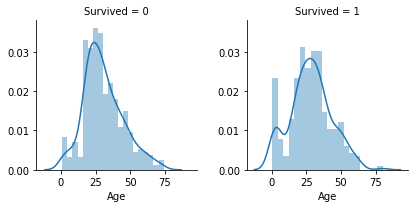

In [13]:
g = sns.FacetGrid(train_y, col='Survived')
g.map(sns.distplot, 'Age', bins=20)

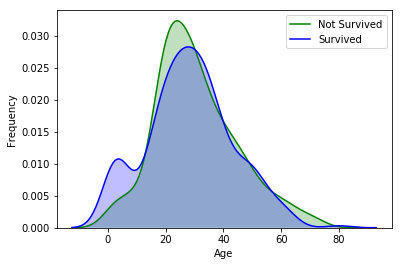

In [14]:
g = sns.kdeplot(train_y["Age"][(train_y["Survived"] == 0) & (train_y["Age"].notnull())], 
                color="Green", shade = True)
g = sns.kdeplot(train_y["Age"][(train_y["Survived"] == 1) & (train_y["Age"].notnull())], 
                ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

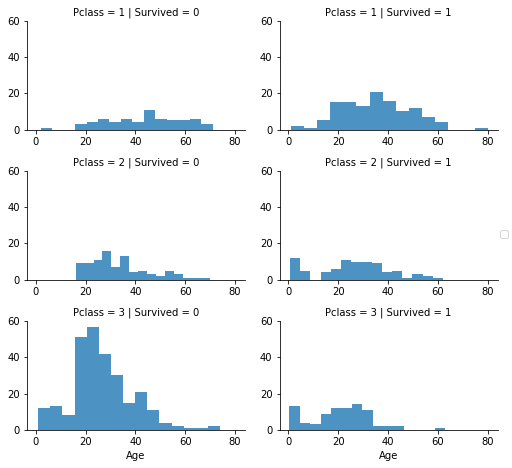

In [15]:
grid = sns.FacetGrid(train_y, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age',alpha=.8, bins=15)
grid.add_legend();

We can see that females are more lucky and they are Survived more that man do.

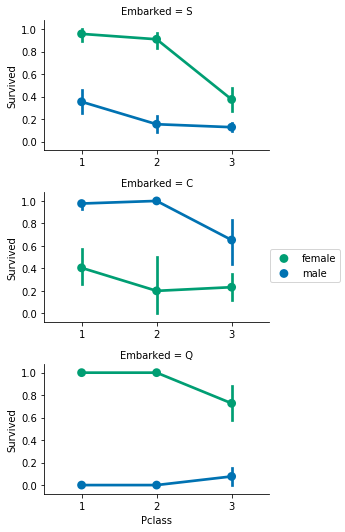

In [16]:
grid = sns.FacetGrid(train_y, row='Embarked', size=2.5, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='colorblind')
grid.add_legend()

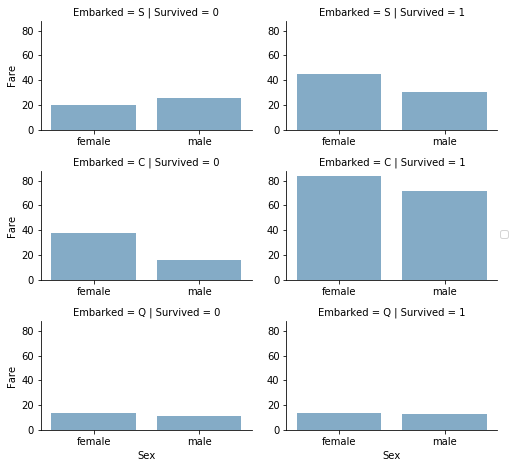

In [17]:
grid = sns.FacetGrid(train_y, row='Embarked', col='Survived', size=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.6, ci=None)
grid.add_legend()

We will examine Pearson Coreelation only for some of the variables.

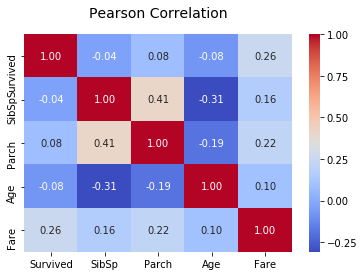

In [18]:
plt.title('Pearson Correlation', y=1.05, size=14)
g = sns.heatmap(train_y[["Survived","SibSp","Parch","Age","Fare"]].corr(),
                annot=True, fmt = ".2f", cmap = "coolwarm")

Until now we dont have change anything in our dataset but now we will drop 'Ticket' and 'Cabin'. We do that because we will need them and now our reasults it will be faster because we will have smaller dataset

In [19]:
train_y = train_y.drop(['Ticket', 'Cabin'], axis=1)
test_y = test_y.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_y, test_y]

In [20]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_y['Title'], train_y['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


As we can see bellow exist some variables that are unreleated so we will make a "team" with them

In [21]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Singular')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_y[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Singular,0.347826


We have to convert the categorical titles to ordinal.

In [22]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_y.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1.0


No we drop 'Name' and 'PassengerId'

In [23]:
train_y = train_y.drop(['Name', 'PassengerId'], axis=1)
test_y = test_y.drop(['Name'], axis=1)
combine = [train_y, test_y]
train_y.shape, test_y.shape

((891, 9), (418, 9))

In [24]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_y.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1.0
1,1,1,1,38.0,1,0,71.2833,C,3.0
2,1,3,1,26.0,0,0,7.9250,S,2.0
3,1,1,1,35.0,1,0,53.1000,S,3.0
4,0,3,0,35.0,0,0,8.0500,S,1.0


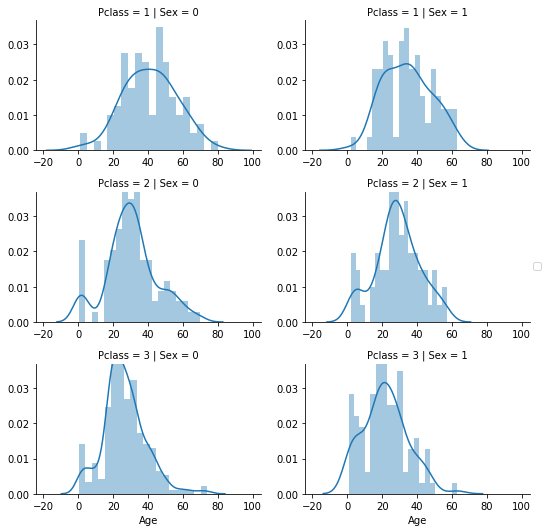

In [25]:
grid = sns.FacetGrid(train_y, row='Pclass', col='Sex', size=2.5, aspect=1.5)
grid.map(sns.distplot, 'Age', bins=20)
grid.add_legend()

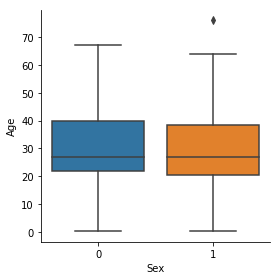

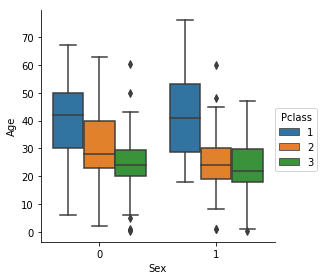

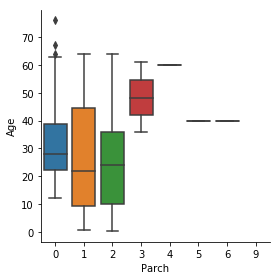

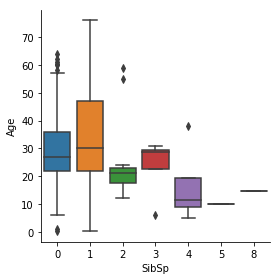

In [26]:
gb = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
gb = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
gb = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
gb = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

We use an empty array to contain guessed Age values based on Pclass , Gender combinations.

In [27]:
guess_ages = np.zeros((2,3))
guess_ages

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [28]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_y = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

        

            age_guess = guess_y.median()

            
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_y.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1.0
1,1,1,1,38,1,0,71.2833,C,3.0
2,1,3,1,26,0,0,7.9250,S,2.0
3,1,1,1,35,1,0,53.1000,S,3.0
4,0,3,0,35,0,0,8.0500,S,1.0


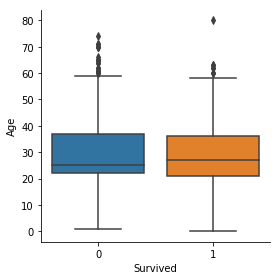

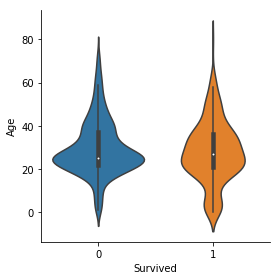

In [29]:
gbn = sns.factorplot(x="Survived", y = "Age",data = train_y, kind="box")
gbn = sns.factorplot(x="Survived", y = "Age",data = train_y, kind="violin")

We generate Age bands

In [30]:
train_y['Age Band'] = pd.cut(train_y['Age'], 5)
train_y[['Age Band', 'Survived']].groupby(['Age Band'], 
    as_index=False).mean().sort_values(by='Age Band', ascending=True)

,Age Band,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


We use age bands in order to replace the original one!

In [31]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_y.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Age Band
0,0,3,0,1,1,0,7.2500,S,1.0,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3.0,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2.0,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3.0,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1.0,"(32.0, 48.0]"


In [32]:
train_y = train_y.drop(['Age Band'], axis=1)
combine = [train_y, test_y]
train_y.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1.0
1,1,1,1,2,1,0,71.2833,C,3.0
2,1,3,1,1,0,0,7.9250,S,2.0
3,1,1,1,2,1,0,53.1000,S,3.0
4,0,3,0,2,0,0,8.0500,S,1.0


We will combine Parch and SibSp and next we will drop from the datasets.

In [33]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_y[['FamilySize', 'Survived']].groupby(['FamilySize'], 
       as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [34]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_y[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [35]:
train_y = train_y.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_y = test_y.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_y, test_y]

train_y.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1.0,0
1,1,1,1,2,71.2833,C,3.0,0
2,1,3,1,1,7.9250,S,2.0,1
3,1,1,1,2,53.1000,S,3.0,0
4,0,3,0,2,8.0500,S,1.0,1


Embarked feature takes S, Q, C values based on port of embarkation. 
We simply fill these with the most common occurance.

In [36]:
freq_port = train_y.Embarked.dropna().mode()[0]
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_y[['Embarked', 'Survived']].groupby(['Embarked'], 
                        as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [37]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_y.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,0,1.0,0
1,1,1,1,2,71.2833,1,3.0,0
2,1,3,1,1,7.9250,0,2.0,1
3,1,1,1,2,53.1000,0,3.0,0
4,0,3,0,2,8.0500,0,1.0,1


We have one missing value it time to correct it!

In [38]:
test_y['Fare'].fillna(test_y['Fare'].dropna().median(), inplace=True)
test_y.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,0,2,7.8292,2,1.0,1
1,893,3,1,2,7.0000,0,3.0,0
2,894,2,0,3,9.6875,2,1.0,1
3,895,3,0,1,8.6625,0,1.0,1
4,896,3,1,1,12.2875,0,3.0,0


In [39]:
train_y['FareBand'] = pd.qcut(train_y['Fare'], 4)
train_y[['FareBand', 'Survived']].groupby(['FareBand'], 
                    as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


We will drop it from our dataset

In [40]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_y = train_y.drop(['FareBand'], axis=1)
combine = [train_y, test_y]

In [41]:
train_y.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,0,0,1.0,0
1,1,1,1,2,3,1,3.0,0
2,1,3,1,1,1,0,2.0,1
3,1,1,1,2,3,0,3.0,0
4,0,3,0,2,1,0,1.0,1


In [42]:
test_y.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,892,3,0,2,0,2,1.0,1
1,893,3,1,2,0,0,3.0,0
2,894,2,0,3,1,2,1.0,1
3,895,3,0,1,1,0,1.0,1
4,896,3,1,1,1,0,3.0,0


Now it is time for our predictions!

In [43]:
X_train = train_y.drop("Survived", axis=1)
Y_train = train_y["Survived"]
X_test  = test_y.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

Logistic Regression


In [44]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

81.480000000000004

Support Vector Machines

In [45]:
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.390000000000001

KNN

In [46]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

85.069999999999993

Gaussian Naive Bayes

In [47]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

78.109999999999999

Linear SVC

In [48]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

81.930000000000007

Decision Tree

In [49]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

86.760000000000005

Random Forest

In [50]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.760000000000005

Now the results in a matrix

In [51]:
models = pd.DataFrame({
    'Model': ['Random Forest','Decision Tree','KNN','Support Vector Machines',  'Logistic Regression', 
               'Linear SVC', 'Naive Bayes'
              ],
    'Score': [acc_random_forest, acc_decision_tree,acc_knn,acc_svc,  acc_log, 
               acc_linear_svc,acc_gaussian]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Random Forest,86.76
1,Decision Tree,86.76
2,KNN,85.07
3,Support Vector Machines,83.39
5,Linear SVC,81.93
4,Logistic Regression,81.48
6,Naive Bayes,78.11
